In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable

In [2]:
# Preprocess and load the MNIST dataset for training and testing with CNN:

# Specify the Mean and standard deviation of all the pixels in the MNIST dataset. They are precomputed: 
mean_gray = 0.1307
stddev_gray = 0.3081

# Transform the images to tensors
# Normalize a tensor image with mean and standard deviation. Given mean: (M1,...,Mn) and std: (S1,..,Sn) 
# for n channels, this transform will normalize each channel of the input torch.Tensor
# i.e. input[channel] = (input[channel] - mean[channel]) / std[channel]

transforms = transforms.Compose([transforms.ToTensor(),  # Convert images to PyTorch tensors.
                                transforms.Normalize((mean_gray,), (stddev_gray,))]) # Normalize the tensors using the precomputed mean and standard deviation.

# Load the MNIST training dataset:
# 'root' specifies the directory to store the dataset.
# 'train=True' indicates that the training dataset is being loaded.
# 'transform=transforms' applies the defined transformation pipeline to the images.
# 'download=True' downloads the dataset if it's not already present in the specified directory.
train_dataset = datasets.MNIST(root = './data', 
                            train = True, 
                            transform = transforms,
                            download = True)

# Load the MNIST testing dataset:
# Similar parameters as the training dataset, but 'train=False' to load the test dataset.
test_dataset = datasets.MNIST(root = './data', 
                            train = False, 
                            transform = transforms)

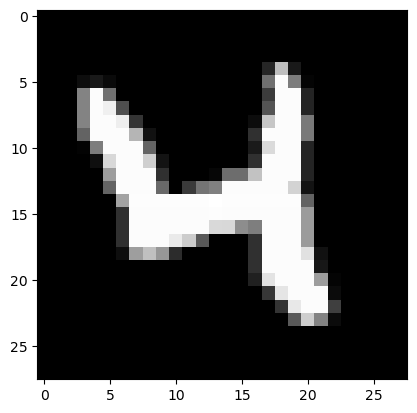

In [3]:
# Display a random image from the MNIST training dataset:

import matplotlib.pyplot as plt

# Extract the 21st image from the training dataset and reverse the normalization process:
random_image = train_dataset[20][0].numpy() * stddev_gray + mean_gray

# Reshape the image from a 1D tensor to a 2D tensor with shape 28x28.
# Display the image using matplotlib with a grayscale color map.
plt.imshow(random_image.reshape(28, 28), cmap='gray')

In [4]:
# Print the corresponding label for the image:
print(train_dataset[20][1])   

4


In [5]:
# Create DataLoader instances for iterating over the MNIST training and testing datasets in batches:

# Set the batch size for loading the data:
batch_size = 100

# DataLoader for the training dataset:
# 'dataset=train_dataset' specifies the dataset to load.
# 'batch_size=batch_size' sets the number of samples per batch.
# 'shuffle=True' randomizes the order of the data for each epoch, which helps in reducing overfitting.
train_load = torch.utils.data.DataLoader(dataset = train_dataset, 
                                         batch_size = batch_size,
                                         shuffle = True)

# DataLoader for the testing dataset:
# Similar to the training loader, but 'shuffle=False' as shuffling is not needed for evaluation.
test_load = torch.utils.data.DataLoader(dataset = test_dataset, 
                                         batch_size = batch_size,
                                         shuffle = False)

In [6]:
print('There are {} images in the training set'.format(len(train_dataset)))
print('There are {} images in the test set'.format(len(test_dataset)))
print('There are {} batches in the train loader'.format(len(train_load)))
print('There are {} batches in the testloader'.format(len(test_load)))

There are 60000 images in the training set
There are 10000 images in the test set
There are 600 batches in the train loader
There are 100 batches in the testloader


![cnn mnist](https://user-images.githubusercontent.com/30661597/61713471-3c957d00-ad8b-11e9-9a38-e3f4d1e72565.png)

In [7]:
# Define the CNN architecture for MNIST classification:

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        # <<Same Padding = [(filter size - 1) / 2] (Same Padding--> input size = output size)>>
        # First convolutional layer with 8 output channels, kernel size 3, stride 1, and padding 1.
        # Padding of 1 maintains the same spatial dimensions (28x28) after this layer.
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3,stride=1, padding=1)
        
        # <<The output size of each of the 8 feature maps is:
        # [(input_size - filter_size + 2(padding) / stride) +1] --> [(28-3+2(1)/1)+1] = 28 (padding type is same)>>
        # Batch normalization for the first convolutional layer.
        self.batchnorm1 = nn.BatchNorm2d(8)
        
        # RELU:
        self.relu = nn.ReLU()
        
        # Max pooling layer with kernel size 2, reduces spatial dimensions by half (28x28 to 14x14):
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        # After max pooling: the output of each feature map is now 28/2 = 14
        
        # Second convolutional layer with 32 output channels, kernel size 5, stride 1, and padding 2:
        # Padding of 2 maintains the same spatial dimensions (14x14) after this layer.
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
        
        # Output size of each of the 32 feature maps remains 14
        
        # Batch normalization for the second convolutional layer:
        self.batchnorm2 = nn.BatchNorm2d(32)
        
        
        # After max pooling, the output of each feature map is 14/2 = 7
        
        # Flatten the feature maps. You have 32 feature maps, each of them is of size 7x7 --> 32*7*7 = 1568
        # <<Fully connected layer to map the flattened feature maps to 600 features.>>
        self.fc1 = nn.Linear(in_features=1568, out_features=600)
        
        # Dropout layer with a dropout probability of 0.5:
        self.droput = nn.Dropout(p=0.5)
        
        # Second fully connected layer to map 600 features to 10 output classes (digits 0-9):
        self.fc2 = nn.Linear(in_features=600, out_features=10)
        
    def forward(self,x):
        
        # Forward pass through the first convolutional layer, batch normalization, ReLU, and max pooling:
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        # Forward pass through the second convolutional layer, batch normalization, ReLU, and max pooling:
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        
        # Flatten the output from the convolutional layers to feed into the fully connected layer:
        # <<The flattened size is 1568, which is calculated from 32 feature maps each of size 7x7.>>
        out = out.view(-1,1568)
        
        # Forward pass through the first fully connected layer with ReLU activation:
        out = self.fc1(out)
        out = self.relu(out)
        
        # Apply dropout to reduce overfitting:
        out = self.droput(out)
        
        # Forward pass through the second fully connected layer to get the final output:
        out = self.fc2(out)
        
        return out

In [8]:
# Initialize the CNN model, set up the loss function, and configure the optimizer:


# Create an instance of the CNN model:
model = CNN()

# Check if CUDA (GPU support) is available and move the model to GPU if it is:
CUDA = torch.cuda.is_available()
if CUDA:
    model = model.cuda()  

# Define the loss function as CrossEntropyLoss, which is commonly used for classification tasks:
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer as Stochastic Gradient Descent (SGD) with a learning rate of 0.01.
# SGD is a basic yet effective optimization algorithm used in training neural networks.
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [9]:
# Understanding the data flow for a single iteration in the training loop:

iteration = 0
correct = 0

# Iterate over the training data once (one batch):
for i,(inputs,labels) in enumerate (train_load):
    # Move the inputs and labels to GPU if CUDA is available.
    if CUDA:
        inputs = inputs.cuda()
        labels = labels.cuda()
    
    # Print details for one iteration:
    print("For one iteration, this is what happens:")
    
    # Display the shape of the inputs. This represents the batch of images:
    print("Input Shape:",inputs.shape)
    
    # Display the shape of the labels. This represents the actual digit labels for the batch:
    print("Labels Shape:",labels.shape)
    
    # Forward pass: Compute the predicted outputs by passing the inputs through the model:
    output = model(inputs)
    
    # Display the shape of the output from the model. This represents the model's predictions:
    print("Outputs Shape",output.shape)
    
    # Get the predicted classes from the maximum value of the outputs:
    _, predicted = torch.max(output, 1)
    
    # Display the shape of the predicted tensor:
    print("Predicted Shape",predicted.shape)
    
    # Print the predicted class labels for the batch:
    print("Predicted Tensor:")
    print(predicted)
    
    # Count how many predictions match the actual labels:
    correct += (predicted == labels).sum()
    
    # Break the loop after one iteration to analyze this single batch:
    break

For one iteration, this is what happens:
Input Shape: torch.Size([100, 1, 28, 28])
Labels Shape: torch.Size([100])
Outputs Shape torch.Size([100, 10])
Predicted Shape torch.Size([100])
Predicted Tensor:
tensor([3, 3, 5, 3, 8, 8, 3, 4, 8, 4, 8, 5, 3, 7, 4, 4, 8, 5, 8, 7, 3, 4, 7, 8,
        3, 8, 7, 8, 7, 3, 7, 3, 7, 3, 8, 7, 4, 5, 2, 3, 3, 3, 8, 8, 6, 4, 4, 7,
        4, 6, 3, 6, 3, 3, 4, 7, 3, 8, 7, 8, 3, 4, 3, 3, 7, 3, 3, 4, 7, 3, 3, 7,
        3, 7, 6, 3, 4, 2, 7, 7, 3, 4, 6, 7, 3, 7, 7, 3, 7, 7, 6, 3, 4, 7, 8, 5,
        7, 3, 3, 4])


## Training & Testing

In [10]:
# Training and testing the CNN over multiple epochs:

num_epochs = 25

# Initialize lists to store the metrics of loss and accuracy for both training and testing:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

# Begin training over multiple epochs:
for epoch in range(num_epochs): 
    # Reset these below variables to 0 at the begining of every epoch:
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    # Set the model to training mode:
    model.train()                 
    
    # Training loop:
    for i, (inputs, labels) in enumerate(train_load):
        
        # Move data to GPU if CUDA is available:
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        # Forward pass: Compute the output of the model:
        outputs = model(inputs)  
        
        # Compute the loss:
        loss = loss_fn(outputs, labels)
        
        # Accumulate the los:
        iter_loss += loss.item()
        
        # Zero the gradients, perform backpropagation, and update the weights:
        # <<w = w - gradient>>
        optimizer.zero_grad()            
        loss.backward()                 
        optimizer.step()                
        
        # Calculate the number of correct predictions:
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iterations += 1
    
    # Record the average training loss and accuracy:
    train_loss.append(iter_loss/iterations)
    train_accuracy.append((100 * correct / len(train_dataset)))
   
    # Testing loop:
    
    testing_loss = 0.0
    correct = 0
    iterations = 0
    
    # Set the model to evaluation mode:
    model.eval()                    
    
    for i, (inputs, labels) in enumerate(test_load):
        # Move data to GPU if CUDA is available:
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        # Forward pass and loss computation:
        outputs = model(inputs)
        
        # Calculate the loss:
        loss = loss_fn(outputs, labels) 
        
        # Accumulate the loss:
        testing_loss += loss.item() 
        
        # Calculate the number of correct predictions:
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iterations += 1

    # Record the average testing loss and accuracy:
    test_loss.append(testing_loss/iterations)
    test_accuracy.append((100 * correct / len(test_dataset)))
    
    # Print the metrics for this epoch:
    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Acc: {:.3f}'
           .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], 
             test_loss[-1], test_accuracy[-1]))

Epoch 1/25, Training Loss: 0.484, Training Accuracy: 87.360, Testing Loss: 0.147, Testing Acc: 95.970
Epoch 2/25, Training Loss: 0.158, Training Accuracy: 95.418, Testing Loss: 0.091, Testing Acc: 97.410
Epoch 3/25, Training Loss: 0.115, Training Accuracy: 96.665, Testing Loss: 0.075, Testing Acc: 97.720
Epoch 4/25, Training Loss: 0.092, Training Accuracy: 97.350, Testing Loss: 0.065, Testing Acc: 97.990
Epoch 5/25, Training Loss: 0.078, Training Accuracy: 97.752, Testing Loss: 0.054, Testing Acc: 98.280
Epoch 6/25, Training Loss: 0.070, Training Accuracy: 97.985, Testing Loss: 0.049, Testing Acc: 98.520
Epoch 7/25, Training Loss: 0.064, Training Accuracy: 98.163, Testing Loss: 0.045, Testing Acc: 98.600
Epoch 8/25, Training Loss: 0.059, Training Accuracy: 98.272, Testing Loss: 0.043, Testing Acc: 98.630
Epoch 9/25, Training Loss: 0.055, Training Accuracy: 98.408, Testing Loss: 0.040, Testing Acc: 98.680
Epoch 10/25, Training Loss: 0.050, Training Accuracy: 98.528, Testing Loss: 0.037,

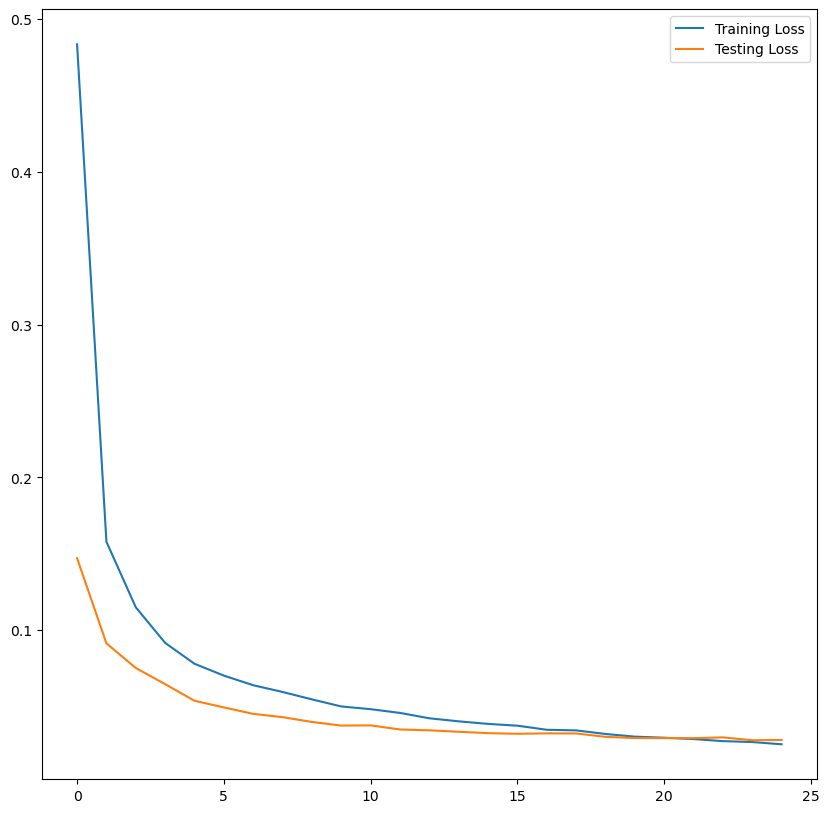

In [11]:
# Plotting the training and testing loss over epochs:

# Create a figure with specified size:
f = plt.figure(figsize=(10, 10))

# Plot the training loss:
plt.plot(train_loss, label='Training Loss')

# Plot the testing loss:
plt.plot(test_loss, label='Testing Loss')

# Add a legend to the plot:
plt.legend()

# Display the plot:
plt.show()

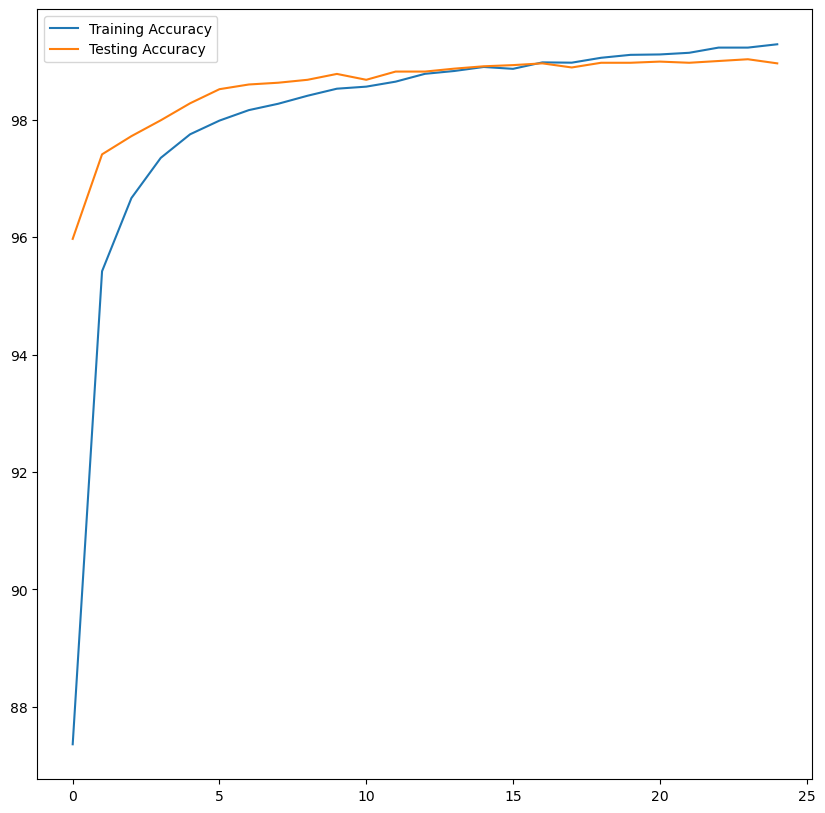

In [12]:
# Plotting the training and testing accuracy over epochs:

# Create a figure with specified size for the accuracy plot:
f = plt.figure(figsize=(10, 10))

# Plot the training accuracy:
plt.plot(train_accuracy, label='Training Accuracy')

# Plot the testing accuracy:
plt.plot(test_accuracy, label='Testing Accuracy')

# Add a legend to differentiate between training and testing accuracy:
plt.legend()

# Display the plot:
plt.show()

In [13]:
# Testing the model with a single image from the test dataset:

# Select and preprocess the 31st image from the test dataset:
img = test_dataset[30][0].resize_((1, 1, 28, 28)) # <<(batch_size,channels,height,width)>>
label = test_dataset[30][1] # Get the actual label of the image.

# Get the actual label of the image:
model.eval()

# Move the model and image to GPU if CUDA is available:
if CUDA:
    model = model.cuda()
    img = img.cuda()

# Forward pass to get the output from the model:
output = model(img)

# Get the predicted class from the maximum value of the outputs:
_, predicted = torch.max(output,1)

# Print the model's prediction and the actual label:
print("Prediction is: {}".format(predicted.item()))
print("Actual is: {}".format(label))

Prediction is: 3
Actual is: 3
